### <p style="text-align:left"><span style="color:green">Importing Required `Libraries`</span></p>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import time

# Data Processing Libraries
import pandas as pd
import numpy as np

# Text Processing Libraries
import re  # Regular Expression library
import contractions
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize  # Tokenization
from gensim.parsing.preprocessing import remove_stopwords
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import gensim

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine Learning Libraries
import sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


### <p style="text-align:left"><span style="color:green">Reading the `CSV File`</span></p>

In [2]:
tweets_df = pd.read_csv('../data/tweets dataset.csv', encoding = "ISO-8859-1")

In [3]:
tweets_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
tweets_df.shape

(9093, 3)

The dataset contains 9093 records and consists in three columns:

* **tweet_text :** The tweet's content
* **emotion_in_tweet_is_directed_at :** The brand mentioned in the tweet
* **is_there_an_emotion_directed_at_a_brand_or_product :** The emotion/neutrality expressed in the tweet   


### <p style="text-align:left"><span style="color:green">Exploring the dataset</span></p>

Let us first check wether our data is cleaned and if there is any missing values

In [5]:
print("The data columns contain the following missing values: ")
tweets_df.isna().sum()

The data columns contain the following missing values: 


tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

As we can see, there is a missing tweet, we will delete it later since it is not relevant in our case. 
There are also 5802 missing values out of 9093 in the *emotion_in_tweet_is_directed_at* column, we will implement an approach to deal with them later since they represent an important percentage of our data which could bring us significant insights and help us in the analysis and visualization part

In order to analyze the tweet's structure and find more about its relationship with the column *emotion_in_tweet_is_directed_at*, we can display fully  some samples :

In [6]:
random_df  =  tweets_df.sample(n = 200)
for i in range(len(random_df)):
    print(random_df.iloc[i][0])
    print(random_df.iloc[i][1])
    print('----------')


#Apple to Open Pop-Up Shop at #SXSW [REPORT]: Apple is set to open a temporary store in the... {link} #realestate #tech
nan
----------
@mention  iPhone. Clearly. Positively. Happily. #SXSW
iPhone
----------
RT @mention There have been two days in the last 6 months when mobile usage of google maps was higher than desktop. - Marissa Mayer #sxsw
nan
----------
Marissa Mayer at #sxsw: 150 Million people use Google Maps on mobile devices. That's up 50% since Aug 2010 - {link} #in
nan
----------
Walked by the mobile Apple store in austin.  Line was insane. #sxsw
nan
----------
UberGenius: Uber Is Taking Control of SXSW Pedicabs {link} #iPhone #LIVESTRONG #NewYorkCity #SanFrancisco #SXSW
nan
----------
.@mention the iPad DJ is setting up at @mention #sxsw
nan
----------
So geeky! Love it! RT @mention Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link}
Apple
----------
Excellent presentation on digital magazines {link} #touchingstories #SXSW
nan
----

By observing and analyzing the above result , we can make some preliminary hypotheses: 
* The tweets don't follow a standard structure, they start sometimes with a mention, other times with an hashtag , and even with simple words directly.
* The brands mentioned in the tweets aren't always simly identifiable,m especially when they are not preceded with an hashtag or a mention, which would make the task of replacing the missing value of the brands comumn harder .
* The tweets contain some insignificant words/ characters, which are not useful and will be deleted

Let's take a look at our target column which is *is_there_an_emotion_directed_at_a_brand_or_product*, and explore the different classes:

In [7]:
tweets_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

It seems that we have 4 classes that rate the emotion expressed in the tweets. howevwr this classes are not well balances, especially the "I can't tell" one : there are so few of these values in comparison with the rest of the classes, and since it won't be so useful for our purpose, we will delete it later.

### <p style="text-align:left"><span style="color:green">Cleaning and preprocessing</span></p>

In [8]:
tweets_df.rename(columns={'tweet_text': 'tweets', 'emotion_in_tweet_is_directed_at': 'brands', 'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'}, inplace=True)

In [9]:
drop_indexes = tweets_df[(tweets_df['emotions'] == "I can't tell")].index
tweets_df.drop(drop_indexes, inplace = True)
tweets_df.dropna(subset = ['tweets'], inplace=True)

In [10]:
tweets_df.isna().sum()

tweets         0
brands      5654
emotions       0
dtype: int64

In [11]:
tweets_df['emotions'].value_counts()

emotions
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

In [12]:
tweets_df['emotions'].value_counts(normalize = True)

emotions
No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: proportion, dtype: float64

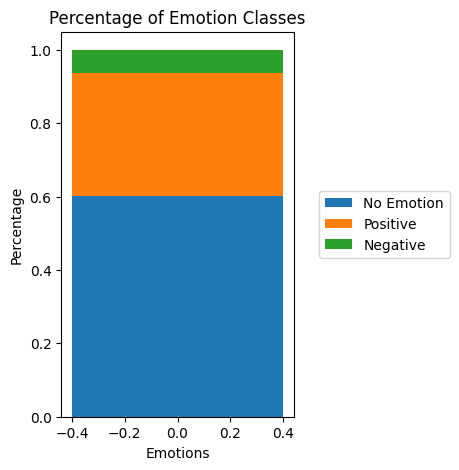

In [13]:
plt.figure(figsize=(3,5))
# Create the classes percentages
percentages = tweets_df['emotions'].value_counts(normalize = True)

# Create bar plot with stacked bars
plt.bar(0, percentages[0], label='No Emotion')
plt.bar(0, percentages[1], bottom=percentages[0], label='Positive')
plt.bar(0, percentages[2], bottom=sum(percentages[:2]), label='Negative')
plt.legend(bbox_to_anchor=(1.7, 0.5), loc="center right")

# Set axis labels and title
plt.xlabel('Emotions')
plt.ylabel('Percentage')
plt.title('Percentage of Emotion Classes')

# Display the plot
plt.show()

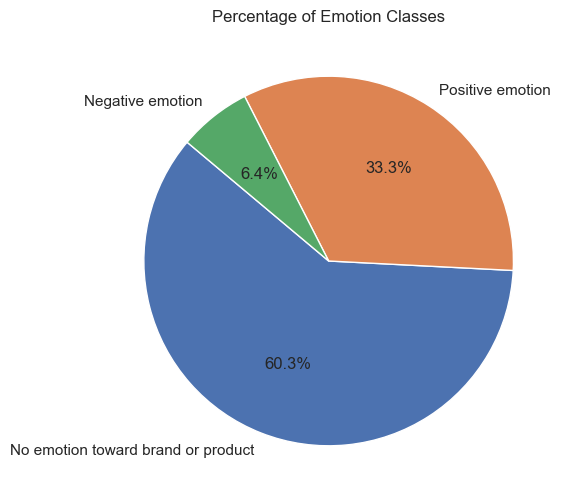

In [14]:
# Calculate the class percentages
percentages = tweets_df['emotions'].value_counts(normalize=True)

# Set the style to use Seaborn's color palette
sns.set(style="whitegrid")

# Create a pie chart (circle plot)
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("deep"))

# Set the title
plt.title('Percentage of Emotion Classes')

# Show the plot
plt.show()

In [15]:
tweets_df['brands'].value_counts()

brands
iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [16]:
grouped_by_emotions = tweets_df.groupby(['emotions'])['brands'].value_counts()
grouped_by_emotions

emotions                            brands                         
Negative emotion                    iPad                               125
                                    iPhone                             103
                                    Apple                               95
                                    Google                              68
                                    iPad or iPhone App                  63
                                    Other Google product or service     47
                                    Android                              8
                                    Android App                          8
                                    Other Apple product or service       2
No emotion toward brand or product  iPad                                24
                                    Apple                               21
                                    Google                              15
                                

<Axes: ylabel='brands'>

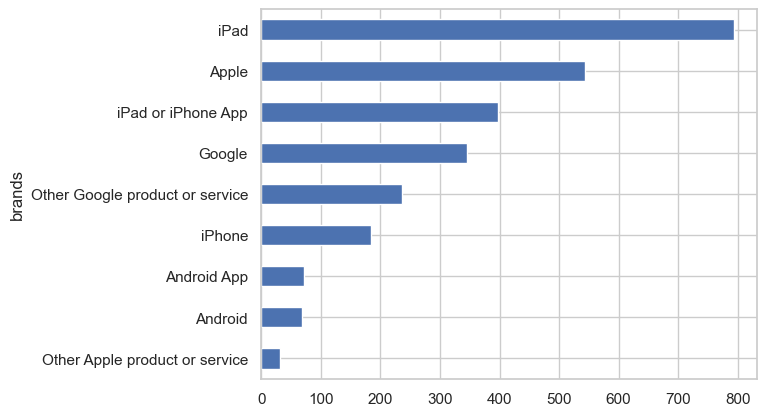

In [17]:
grouped_by_emotions['Positive emotion'].sort_values().plot(kind='barh', stacked=True)

<Axes: ylabel='brands'>

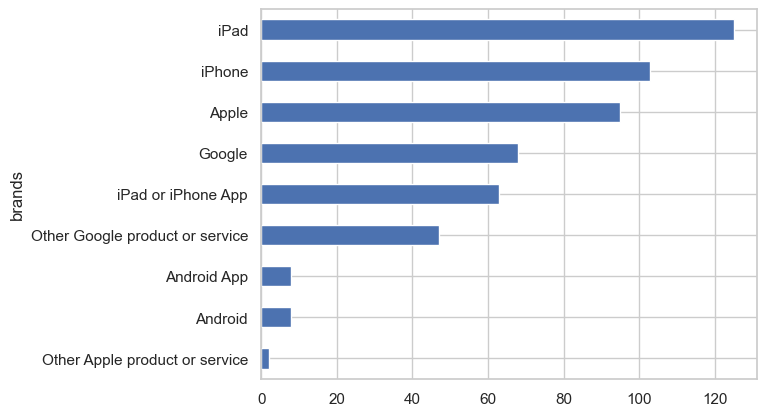

In [18]:
grouped_by_emotions['Negative emotion'].sort_values().plot(kind='barh', stacked=True)

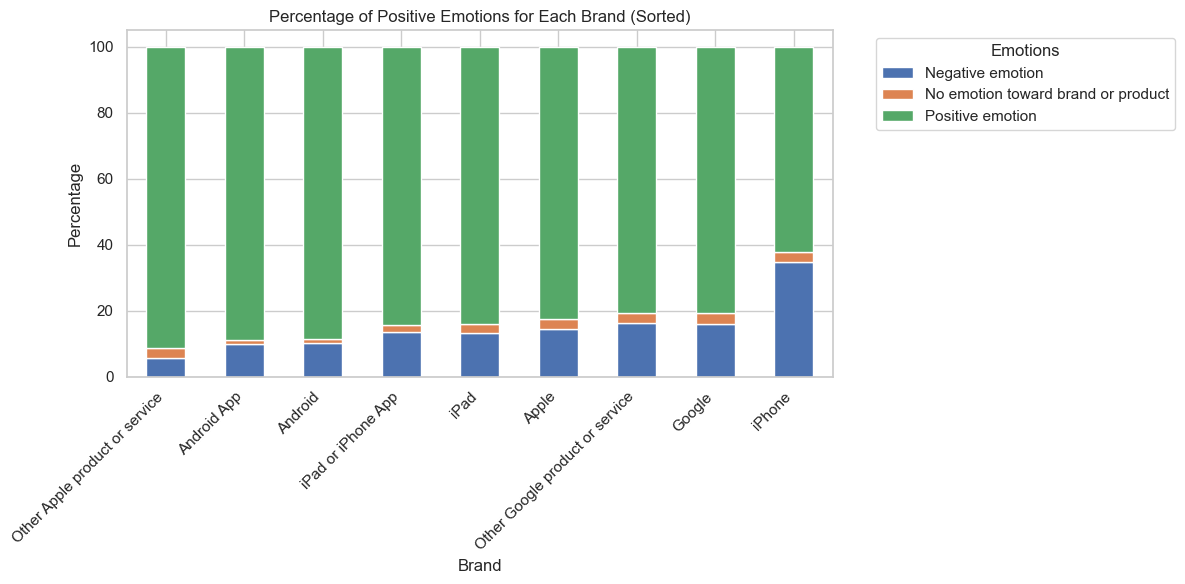

In [19]:
# Group the data by 'brands' and 'emotions' and calculate the count of each combination
grouped = tweets_df.groupby(['brands', 'emotions']).size().unstack()

# Calculate the total count of each brand
total_counts = grouped.sum(axis=1)

# Calculate the percentages
percentage_data = grouped.div(total_counts, axis=0) * 100

# Sort the DataFrame by the percentage of positive emotion in descending order
sorted_percentage_data = percentage_data.sort_values(by='Positive emotion', ascending=False)

# Create a stacked bar plot
ax = sorted_percentage_data.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_xlabel('Brand')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Positive Emotions for Each Brand (Sorted)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add a legend
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Viz the destribution of each class in the traget

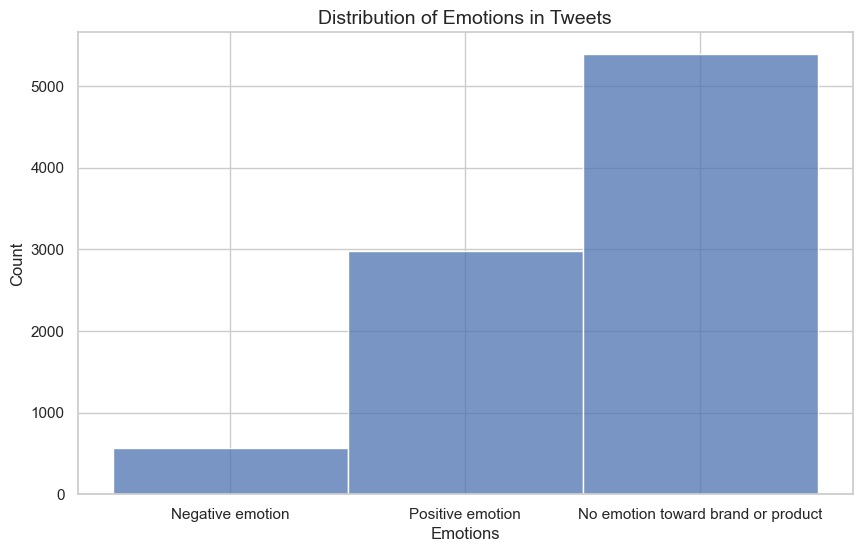

In [20]:
plt.figure(figsize=(10, 6))

# Create the histogram plot with custom parameters
sns.histplot(data=tweets_df, x='emotions')

# Add labels and title for better understanding
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Emotions in Tweets', fontsize=14)

# Display the plot
plt.show()

In [21]:
tweets_df

,tweets,brands,emotions
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [22]:
# WORD-COUNT
dataframe = tweets_df.copy(deep=True)
dataframe['word_count'] = dataframe['tweets'].apply(lambda x: len(str(x).split()))

dict_emotions_wordcount = {}
emotions_names = list(dataframe.emotions.unique())

for emotion in emotions_names:
    mean_word_count = dataframe[dataframe['emotions'] == emotion]['word_count'].mean()
    dict_emotions_wordcount[emotion] = mean_word_count

# Print the dictionary containing emotions and their corresponding average word count
print(dict_emotions_wordcount)


{'Negative emotion': 18.756140350877192, 'Positive emotion': 18.180658159838817, 'No emotion toward brand or product': 17.43504083147736}


In [23]:
for key, value in dict_emotions_wordcount.items():
    print(key, ' : ', value)

Negative emotion  :  18.756140350877192
Positive emotion  :  18.180658159838817
No emotion toward brand or product  :  17.43504083147736


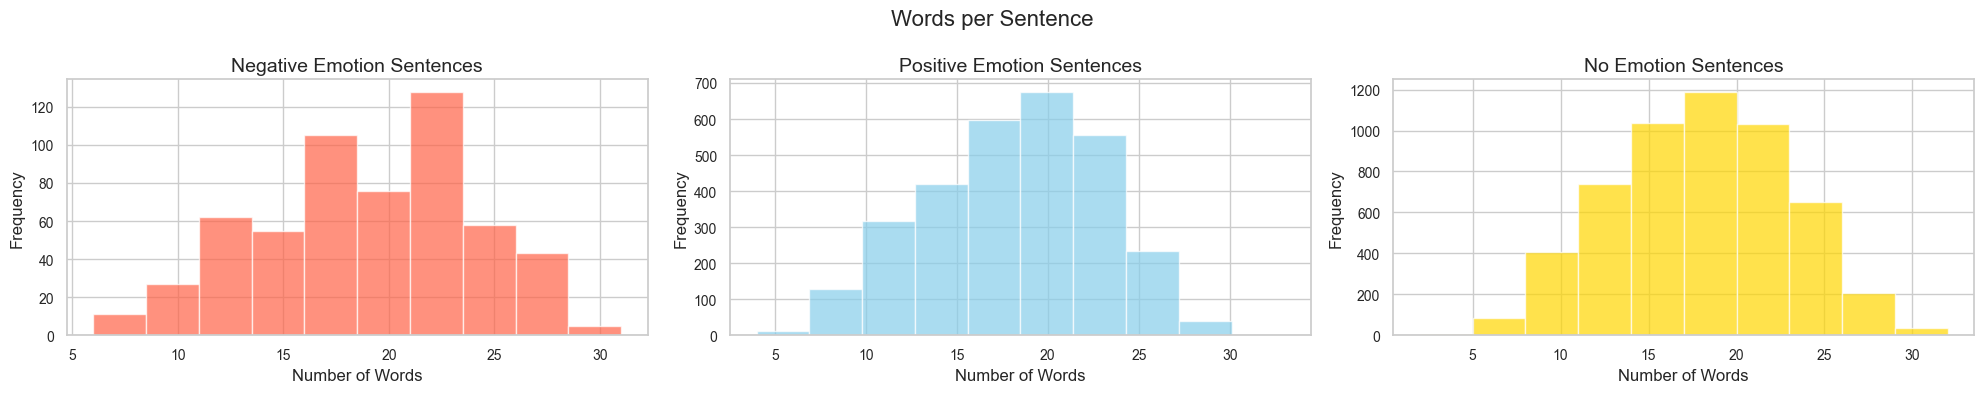

In [24]:
# Define colors for the plots
colors = ['#FF6347', '#87CEEB', '#FFD700']

# PLOTTING WORD-COUNT
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

# Extract sentences for each emotion category
negative_emotion_sentences = dataframe[dataframe['emotions'].str.contains("Negative emotion")]['tweets']
ax1.hist(negative_emotion_sentences.apply(lambda x: len(x.split())), color=colors[0], alpha=0.7)
ax1.set_title('Negative Emotion Sentences', fontsize=14)

positive_emotion_sentences = dataframe[dataframe['emotions'].str.contains("Positive emotion")]['tweets']
ax2.hist(positive_emotion_sentences.apply(lambda x: len(x.split())), color=colors[1], alpha=0.7)
ax2.set_title('Positive Emotion Sentences', fontsize=14)

no_emotions_sentences = dataframe[dataframe['emotions'].str.contains("No emotion")]['tweets']
ax3.hist(no_emotions_sentences.apply(lambda x: len(x.split())), color=colors[2], alpha=0.7)
ax3.set_title('No Emotion Sentences', fontsize=14)

# Set common title for the subplots
fig.suptitle('Words per Sentence', fontsize=16)

# Set common x and y labels for subplots
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Number of Words', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

### 5️⃣  `Data Preprocessing ` :

> Our data generally comes from a variety of different sources and is often in a variety of different formats. For this reason, cleaning our raw data is an essential part of preparing our dataset. However, cleaning is not a simple process, as textual data often contains redundant and/or repetitive words.

> Before training the model, we will perform various pre-processing steps on the dataset such as: 
>- Converting the text document to lowercase for better generalization.
>- Removing stop words.
>- Removing emojis. 
>- Removing of mentions & hastags.
>- Removal of numbers.
>- Removal of whitespaces.
>- Cleaning the ponctuation (to reduce unnecessary noise from the dataset).
>- Removing the repeating characters from the words along with removing the URLs/hyperlinks as they do not have any significant importance. <br>                          
and much more, we will see this in detail later...

> We will then performe:
>- **`Stemming`** : reducing the words to their derived stems.
>- **`Lemmatization`** : reducing the derived words to their root form known as lemma for better results.

> - **`Lowering Case`**:

Lowering case is very imprtant since it allows us to make words with same value equal. This will be very useful to reduce the dimensions of our vocabulary.

> - **`Removal of Mentions`**:

In social media, Mentions are used to call/mention another user into our post. Generally, mentions don't have an added value to our model. So we will remove them.

A mention has a special pattern: **@UserName** or  **#UserName**, So we will remove all string which starts with @

 > - **`Removal of Special Characters`**:
 
Special characters are every where, since we have punctuation marks in our tweets. In order to treat, for example, **hello!** and **hello** in the same way.  we have to remove the punctuation mark **!**

In [25]:
# Function to remove mentions (usernames starting with @ and hashtags starting with #)
def remove_mentions(text):
    text = re.sub(r"@\S+|#\S+", "", text)
    return text

# Function to remove punctuations, special characters, and symbols
def remove_punctuations(text):
    punct = re.compile("[@$#.;:!?_/,{}\-\\\"()\[\]]")
    text = punct.sub(" ", text)
    return re.sub(r"\'", " ", text)

# Function to remove small words (1 and 2 characters)
def remove_small_words(text):
    text = re.sub(r"\b\w{1,3}\b", " ", text)
    return text

# Function to remove hyperlinks starting with http or https
def remove_links(text):
    return re.sub(r"http\S+", " ", text)

# Function to remove numbers
def remove_numbers(text):
    return re.sub(r"[0-9]+", " " , text)

# Function to remove placeholder "{link}" with an empty string
def remove_link_placeholder(text):
    text = re.sub(r"\b(?:sxsw|mention)\b", " ", text)
    return re.sub(r'\{link\}', '', text)
    

# Function to remove extra whitespaces and leading/trailing whitespaces
def remove_whitespaces(text):
    text = text.strip()
    return re.sub(r" +", " ", text)

# Main processing function
def process(data):
    # Convert text to lowercase
    data = data.str.lower()
    # Apply functions sequentially to the data
    data = data.apply(remove_link_placeholder)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_mentions)
    # Remove stopwords using NLTK library
    stop_words = set(stopwords.words('english'))
    data = data.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    data = data.apply(remove_links)
    data = data.apply(remove_numbers)
    data = data.apply(remove_small_words)
    data = data.apply(remove_whitespaces)
    return data


In [26]:
tweets_df['tweets_processed'] = process(tweets_df['tweets'])

In [27]:
tweets_df

,tweets,brands,emotions,tweets_processed
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone tweeting rise austin dead need u...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipad iphone like...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff marissa mayer google rei...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,wave buzz interrupt regularly scheduled geek p...
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,google zeiger physician never reported potenti...
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,verizon iphone customers complained time fell ...


In [28]:
from nltk.tokenize import word_tokenize

tweets_df['tweets_tokenized'] = tweets_df['tweets_processed'].apply(word_tokenize)

In [29]:
brands = [x.lower() for x in tweets_df['brands'].dropna().unique()]

def fill_brands(tweet_tokenized):
    b= []
    for x in tweet_tokenized:
        if (x in brands and x not in b):
            b.append(x)
    return(" or ".join(b))

tweets_df['brands'] = tweets_df['brands'].fillna(tweets_df['tweets_tokenized'].apply(fill_brands))

In [30]:
brands = [x.lower() for x in tweets_df['brands'].dropna().unique()]

def fill_brands(tweet_tokenized):
    b= []
    for x in tweet_tokenized:
        if (x in brands and x not in b):
            b.append(x)
    return(" or ".join(b))

tweets_df['brands'] = tweets_df['brands'].fillna(tweets_df['tweets_tokenized'].apply(fill_brands))

In [31]:
tweets_df = tweets_df.drop(['tweets'], axis=1)
tweets_df

,brands,emotions,tweets_processed,tweets_tokenized
0,iPhone,Negative emotion,wesley iphone tweeting rise austin dead need u...,"[wesley, iphone, tweeting, rise, austin, dead,..."
1,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipad iphone like...,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,iPad,Positive emotion,swonderlin wait ipad also sale,"[swonderlin, wait, ipad, also, sale]"
3,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone,"[hope, year, festival, crashy, year, iphone]"
4,Google,Positive emotion,sxtxstate great stuff marissa mayer google rei...,"[sxtxstate, great, stuff, marissa, mayer, goog..."
...,...,...,...,...
9088,iPad,Positive emotion,ipad everywhere,"[ipad, everywhere]"
9089,google,No emotion toward brand or product,wave buzz interrupt regularly scheduled geek p...,"[wave, buzz, interrupt, regularly, scheduled, ..."
9090,google,No emotion toward brand or product,google zeiger physician never reported potenti...,"[google, zeiger, physician, never, reported, p..."
9091,iphone,No emotion toward brand or product,verizon iphone customers complained time fell ...,"[verizon, iphone, customers, complained, time,..."


### I.3 Experimentation with classification

We are going to use the scikit-learn ```MultinomialNB```, an implementation of the Naive Bayesian model.:

The naïve hypothesis assumes that the features(words) are conditionally independent of each other, given the class.

#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents.

## Model training: SVM classifier with TfidfVectorizer

In [32]:
# Importing libraries needed for model training

In [33]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
# Quick overview of the dataset we use for training the model

In [35]:
tweets_df

,brands,emotions,tweets_processed,tweets_tokenized
0,iPhone,Negative emotion,wesley iphone tweeting rise austin dead need u...,"[wesley, iphone, tweeting, rise, austin, dead,..."
1,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipad iphone like...,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,iPad,Positive emotion,swonderlin wait ipad also sale,"[swonderlin, wait, ipad, also, sale]"
3,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone,"[hope, year, festival, crashy, year, iphone]"
4,Google,Positive emotion,sxtxstate great stuff marissa mayer google rei...,"[sxtxstate, great, stuff, marissa, mayer, goog..."
...,...,...,...,...
9088,iPad,Positive emotion,ipad everywhere,"[ipad, everywhere]"
9089,google,No emotion toward brand or product,wave buzz interrupt regularly scheduled geek p...,"[wave, buzz, interrupt, regularly, scheduled, ..."
9090,google,No emotion toward brand or product,google zeiger physician never reported potenti...,"[google, zeiger, physician, never, reported, p..."
9091,iphone,No emotion toward brand or product,verizon iphone customers complained time fell ...,"[verizon, iphone, customers, complained, time,..."


In [36]:
# Data separation

In [38]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

emotions = tweets_df['emotions'].unique()
emotions_encoded = label_encoder.fit_transform(emotions)
print(dict(zip(emotions, emotions_encoded)))

tweets_df['emotions'] = label_encoder.fit_transform(tweets_df['emotions'])

{'Negative emotion': 0, 'Positive emotion': 2, 'No emotion toward brand or product': 1}


In [39]:
tweets_df

,brands,emotions,tweets_processed,tweets_tokenized
0,iPhone,0,wesley iphone tweeting rise austin dead need u...,"[wesley, iphone, tweeting, rise, austin, dead,..."
1,iPad or iPhone App,2,jessedee know fludapp awesome ipad iphone like...,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,iPad,2,swonderlin wait ipad also sale,"[swonderlin, wait, ipad, also, sale]"
3,iPad or iPhone App,0,hope year festival crashy year iphone,"[hope, year, festival, crashy, year, iphone]"
4,Google,2,sxtxstate great stuff marissa mayer google rei...,"[sxtxstate, great, stuff, marissa, mayer, goog..."
...,...,...,...,...
9088,iPad,2,ipad everywhere,"[ipad, everywhere]"
9089,google,1,wave buzz interrupt regularly scheduled geek p...,"[wave, buzz, interrupt, regularly, scheduled, ..."
9090,google,1,google zeiger physician never reported potenti...,"[google, zeiger, physician, never, reported, p..."
9091,iphone,1,verizon iphone customers complained time fell ...,"[verizon, iphone, customers, complained, time,..."


In [48]:
tweets_df['emotions'].value_counts()

emotions
1    5388
2    2978
0     570
Name: count, dtype: int64

In [40]:
# Separating the 95% data for training data and 10% for testing data
X = tweets_df['tweets_processed']
y = tweets_df.emotions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [41]:
# Create the CountVectorizer
vectorizer = TfidfVectorizer(max_features=1000 , analyzer='word')
# Fit the vectorizer on the training data to build the vocabulary
# Convert the training and validation texts into bag-of-words representation
train_bow = vectorizer.fit_transform(X_train)
test_bow = vectorizer.transform(X_test)

In [42]:
# Feature Vectorizing

In [43]:
vectorizer.get_feature_names_out()

array(['able', 'access', 'accessibility', 'aclu', 'across', 'action',
       'actually', 'added', 'afford', 'agnerd', 'agree', 'airport',
       'alarm', 'album', 'almost', 'already', 'also', 'always', 'amazing',
       'amazon', 'america', 'among', 'analytics', 'android', 'announce',
       'announced', 'announcement', 'announces', 'another', 'anyone',
       'anything', 'anywhere', 'apparently', 'appears', 'apple', 'apps',
       'aquent', 'around', 'arrived', 'article', 'artists', 'asked',
       'attend', 'attendees', 'attending', 'attention', 'audience',
       'augmented', 'austin', 'available', 'awards', 'away', 'awesome',
       'back', 'badge', 'ballroom', 'band', 'bands', 'barry', 'based',
       'battery', 'bavcid', 'beautiful', 'becoming', 'beer', 'begins',
       'behind', 'believe', 'belinsky', 'beluga', 'best', 'beta',
       'better', 'bettersearch', 'beyond', 'bigger', 'biggest', 'bing',
       'bizzy', 'black', 'blackberry', 'block', 'blocks', 'blog',
       'blogger'

In [44]:
# Performing classification

In [45]:
classifier = svm.SVC(kernel='poly')
t0 = time.time()
classifier.fit(train_bow, y_train)
t1 = time.time()
y_pred_svm = classifier.predict(test_bow)
t2 = time.time()

Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.16      0.25       126
           1       0.67      0.89      0.77      1094
           2       0.64      0.35      0.45       568

    accuracy                           0.67      1788
   macro avg       0.65      0.47      0.49      1788
weighted avg       0.66      0.67      0.63      1788



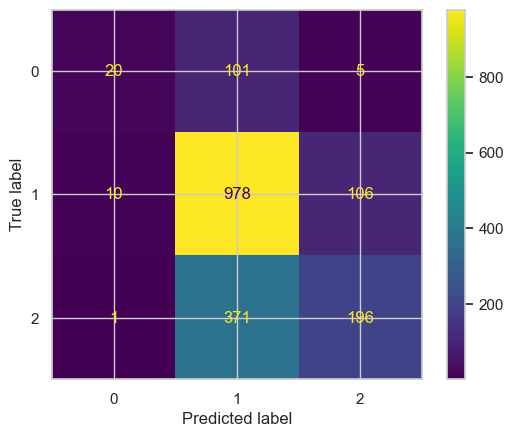

In [46]:
# Evaluate the model
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = classifier.classes_)
disp.plot()

print("\nClassification Report:")
report = classification_report(y_test, y_pred_svm)
print(report)

In [47]:
time_linear_train = t1-t0 # The time needed to train our linear classifier
time_linear_predict = t2-t1 # The time needed to predict with our trained linear classifier

print("Training time: {:.2f}s; Prediction time: {:.2f}s".format(time_linear_train, time_linear_predict))

Training time: 13.14s; Prediction time: 1.72s
